# **Modified MNIST Classification**
<b>Project 3 - COMP551: Applied Machine Learning, McGill University<br>
Group 98 - Shantanil Bagchi, Nikhil Podila, and Mehdi Amian</b>

## Loading required resources
Loading required libraries, tensorboard and google drive link from google colab.

In [0]:
#Importing the required libraries 
%matplotlib inline
import numpy  as np  
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import keras
import h5py
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import glob

from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint, Callback
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization, TimeDistributed, LSTM
from keras.layers import Conv2D, MaxPooling2D, Activation, MaxPool2D, Convolution2D
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop, Adam, Nadam
from keras.utils.np_utils import to_categorical,normalize
from keras import backend as K
from keras import optimizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings("ignore")

import datetime
%load_ext tensorboard

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/McGill/Fall 2019/COMP551/Project 3")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!nvidia-smi

Tue Nov 12 04:57:11 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Loading Modified MNIST Dataset and arranging the inputs for CNN models



In [0]:
#Loading the data
train_images = pd.read_pickle("train_max_x")
y_train = pd.read_csv("train_max_y.csv")["Label"]
test_images = pd.read_pickle("test_max_x")

Train_images=train_images
Test_images=test_images
Y_train=y_train

In [0]:
# One hot encoding
y_train = to_categorical(y_train)

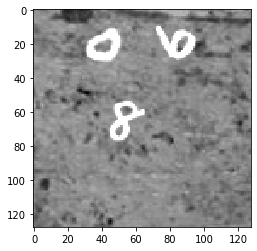

In [0]:
# Example image
plt.imshow(test_images[5], cmap="gray")
plt.show()

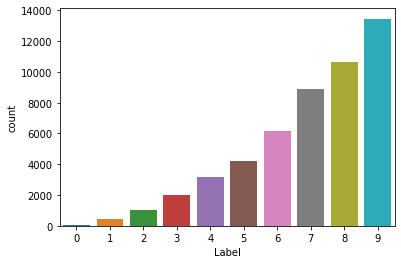

In [0]:
# Plotting the Histogram for the training set labels 
g = sns.countplot(Y_train)

In [0]:
#Reshaping the data
train_images=train_images.reshape(train_images.shape[0],128,128,1)
test_images=test_images.reshape(test_images.shape[0],128,128,1)

# Splitting data into Training and Hold-out validation sets, and data augmentation

In [0]:
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(train_images, y_train, test_size=0.1, random_state=7)
y_test=y_test_d

In [0]:
datagen = ImageDataGenerator(
    #rescale=1. / 255,
    rotation_range=20, 
    width_shift_range=0.1,
    shear_range=0.2,
    height_shift_range=0.1,
    zoom_range=0.2
    )

datagen.fit(X_train_d)

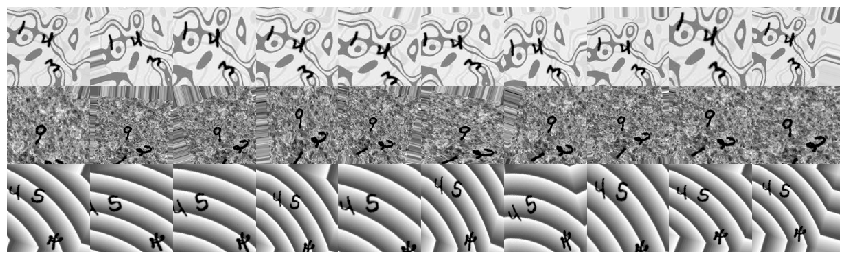

In [0]:
# PREVIEW AUGMENTED IMAGES
X_train3 = X_train_d[9,].reshape((1,128,128,1))
Y_train3 = y_train_d[9,].reshape((1,10))
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    X_train2, Y_train2 = datagen.flow(X_train3,Y_train3).next()
    plt.imshow(X_train2[0].reshape((128,128)),cmap=plt.cm.binary)
    plt.axis('off')
    if i==9: X_train3 = X_train_d[2,].reshape((1,128,128,1))
    if i==19: X_train3 = X_train_d[10,].reshape((1,128,128,1))
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

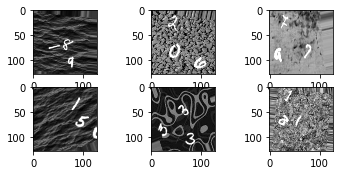

In [0]:
for X_batch, y_batch in datagen.flow(X_train_d, y_train_d, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_batch[i].reshape(128, 128), cmap=plt.get_cmap('gray'))
	# show the plot
	plt.show()
	break

# Defining CNN Models

In [0]:
# Callbacks
# Hyperparameters for our models
# ReduceonPlateau: Stops updating the learning weights for the models when the accuracy does not improve
lr_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                 patience=3, 
                                 verbose=1, 
                                 factor=0.5, 
                                 min_lr=0.00001)

In [0]:
def CNN_basic(input_shape):
    
  # One layer CNN
    nets = 3

  # Model creation
    model = Sequential()

  # Model layers
    model.add(Conv2D(16,kernel_size=5,padding='same',activation='relu', input_shape=input_shape))
    model.add(MaxPool2D())
    model.add(Conv2D(32,kernel_size=5,padding='same',activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(256,kernel_size=5,padding='same',activation='relu'))
    model.add(MaxPool2D(padding='same'))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# Checkpointing
#filepath="weights-improvement-trial_gen-{epoch:02d}-{val_acc:.2f}.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#callbacks_list = [checkpoint]

In [0]:
  def VGG_modified(input_shape, opt = optimizers.Adam(amsgrad=True)):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu', input_shape=input_shape,
                            data_format="channels_last"))
    model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    #sgd=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# Checkpointing
filepath="weights-improvement-trial-randomstate_7.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [0]:
# METRICS TO BE UPDATED
class DisplayMetrics(Callback):
    def __init__(self, filename):
        self.filename = filename
        pass
    
    def on_epoch_end(self, epoch, logs={}):
        with open(self.filename, "a") as f:
            for k,v in logs.items():
                f.write(str(k)+","+str(v)+",")
                pass
            f.write("\n")
            pass
        pass
    pass
pass

callbacks_list += [DisplayMetrics("logging_doctrialstate_7.csv")]

# Model Training

In [0]:
%tensorboard --logdir ./tensorboard_trial/log_20191110_load1

In [0]:
model1 = VGG_modified((128,128,1))

### CODE BELOW TAKEN FROM: https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks
logdir = os.path.join("./tensorboard_trial/log_20191110_load1", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=0)
callbacks_list += [tensorboard_callback]

history1 = model1.fit_generator(datagen.flow(X_train_d, y_train_d, batch_size=200),
                              validation_data=(X_test_d, y_test_d),
                              epochs = 85, callbacks=callbacks_list )

# Model Ensembling - Voting

In [0]:
selected_model_files = glob.glob("./Final_models/*.hdf5")
selected_models = [load_model(model_item) for model_item in selected_model_files]

# model1 = load_model('weights-improvement-trial-randomstate7.hdf5')
# model3 = load_model('weights-improvement-trialstate0.hdf5')
# model4 = load_model('trial1_20191103_1200new.hdf5')
# model5 = load_model('weights-improvement-trialstate99.hdf5')
# model6 = load_model('weights-improvement-trialstate2.hdf5')
# model2 = load_model('best_weights_20191109_-72.hdf5')













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
# Model ensembling using Voting - Held-out validation set results
results = np.zeros( (X_test_d.shape[0],10) )
for model_item in selected_models:
  results += model_item.predict(X_test_d)
results = np.argmax(results,axis = 1)

# results = results + model1.predict(X_test_d)
# results = results + model2.predict(X_test_d)
# results = results + model3.predict(X_test_d)
# results = results + model4.predict(X_test_d)
# results = results + model5.predict(X_test_d)
# results = results + model6.predict(X_test_d)

In [0]:
y_test=np.argmax(y_test, axis = 1)

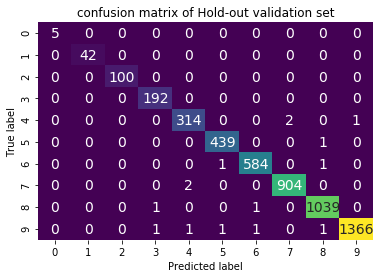

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00        42
           2       1.00      1.00      1.00       100
           3       0.99      1.00      0.99       192
           4       0.99      0.99      0.99       317
           5       1.00      1.00      1.00       440
           6       1.00      1.00      1.00       586
           7       1.00      1.00      1.00       906
           8       1.00      1.00      1.00      1041
           9       1.00      1.00      1.00      1371

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000

Accuracy score: 99.70%


In [0]:
# Confusion matrix, Accuracy score for the validation set
conf_mat = confusion_matrix(results , y_test) 
ax = sns.heatmap(conf_mat, annot=True,annot_kws={"size": 14},fmt='g', cbar=False, cmap="viridis")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("confusion matrix of Hold-out validation set")
plt.show()
print(classification_report(results,y_test))  
Accuracy = accuracy_score(results, y_test)
print ("Accuracy score: {0:.2f}%".format(Accuracy*100))

In [0]:
# Model ensembling using Voting - Test dataset results

results_test = np.zeros( (test_images.shape[0],10) )
for model_item in selected_models:
  results_test += model_item.predict(test_images) 
results_test = np.argmax(results_test,axis = 1)

# results_test = results_test + model1.predict(test_images)
# results_test = results_test + model2.predict(test_images)
# results_test = results_test + model3.predict(test_images)
# results_test = results_test + model4.predict(test_images)
# results_test = results_test + model5.predict(test_images)
# results_test = results_test + model6.predict(test_images)

1


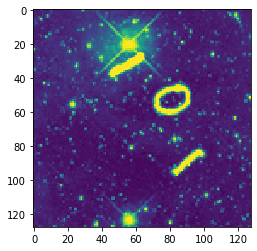

In [0]:
seed = 4651
print(results_test[seed])
plt.imshow(Test_images[seed])

# Storing results

In [0]:
df = pd.DataFrame(data={"Id":range(results_test.shape[0]), "Label":results_test})
df.to_csv("MNIST-CNN-ENSEMBLE7.csv",index=False,header=True)

# Comparison of Optimizers

In [0]:
# Comparison of optimisers
# Change the optimiser in function CNN_model
# Different optimisers used for comparison are adam, nadam, rmsprop, sgd with momentum and sgd with momentum and nestrov,adamax
# Change adam() for adam in model.compile in CNN_model
model_adam = VGG_modified((128,128,1))

### CODE BELOW TAKEN FROM: https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks
logdir = os.path.join("./tensorboard_trial/log_20191110_adam", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=0)
callbacks_list = [tensorboard_callback]

history_adam = model_adam.fit_generator(datagen.flow(X_train_d, y_train_d, batch_size=200),
                              validation_data=(X_test_d, y_test_d),
                              epochs = 15, callbacks=callbacks_list
                              )

In [0]:
#Change Nadam() for Nadam in model.compile in CNN_model
model_nadam = VGG_modified((128,128,1), optimizers.Nadam())

### CODE BELOW TAKEN FROM: https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks
logdir = os.path.join("./tensorboard_trial/log_20191110_nadam", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=0)
callbacks_list = [tensorboard_callback]

history_nadam = model_nadam.fit_generator(datagen.flow(X_train_d, y_train_d, batch_size=200),
                              validation_data=(X_test_d, y_test_d),
                              epochs = 15 , callbacks=callbacks_list
                              )

Epoch 1/15
200/200 [==============================] - 64s 321ms/step - loss: 2.6506 - acc: 0.2416 - val_loss: 13.3429 - val_acc: 0.1719
Epoch 2/15
200/200 [==============================] - 59s 295ms/step - loss: 2.2616 - acc: 0.2589 - val_loss: 2.2368 - val_acc: 0.2337
Epoch 3/15
200/200 [==============================] - 59s 295ms/step - loss: 2.1200 - acc: 0.2634 - val_loss: 2.0100 - val_acc: 0.2751
Epoch 4/15
200/200 [==============================] - 59s 295ms/step - loss: 1.9752 - acc: 0.2665 - val_loss: 1.8991 - val_acc: 0.2770
Epoch 5/15
200/200 [==============================] - 59s 295ms/step - loss: 1.9048 - acc: 0.2662 - val_loss: 1.8876 - val_acc: 0.2761
Epoch 6/15
200/200 [==============================] - 59s 295ms/step - loss: 1.8923 - acc: 0.2653 - val_loss: 2.2641 - val_acc: 0.2772
Epoch 7/15
200/200 [==============================] - 59s 295ms/step - loss: 1.8691 - acc: 0.2747 - val_loss: 2.0641 - val_acc: 0.1753
Epoch 8/15
200/200 [==============================] - 

In [0]:
#Change 'rmsprop' for rmsprop in model.compile in CNN_model
model_rmsprop = VGG_modified((128,128,1), optimizers.RMSprop())

### CODE BELOW TAKEN FROM: https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks
logdir = os.path.join("./tensorboard_trial/log_20191110_rmsprop", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=0)
callbacks_list = [tensorboard_callback]

history_rmsprop = model_rmsprop.fit_generator(datagen.flow(X_train_d, y_train_d, batch_size=200),
                              validation_data=(X_test_d, y_test_d),
                              epochs = 15 , callbacks=callbacks_list 
                              )


Epoch 1/15
200/200 [==============================] - 64s 318ms/step - loss: 2.6053 - acc: 0.2367 - val_loss: 2.1122 - val_acc: 0.1902
Epoch 2/15
200/200 [==============================] - 58s 292ms/step - loss: 1.9196 - acc: 0.2541 - val_loss: 2.2926 - val_acc: 0.2766
Epoch 3/15
200/200 [==============================] - 59s 293ms/step - loss: 1.9041 - acc: 0.2623 - val_loss: 12.7478 - val_acc: 0.2091
Epoch 4/15
200/200 [==============================] - 59s 293ms/step - loss: 1.8490 - acc: 0.2853 - val_loss: 1.8929 - val_acc: 0.2770
Epoch 5/15
200/200 [==============================] - 59s 293ms/step - loss: 1.5881 - acc: 0.4185 - val_loss: 3.0223 - val_acc: 0.2091
Epoch 6/15
200/200 [==============================] - 59s 293ms/step - loss: 1.2390 - acc: 0.5914 - val_loss: 1.8378 - val_acc: 0.4368
Epoch 7/15
200/200 [==============================] - 59s 293ms/step - loss: 0.9393 - acc: 0.6936 - val_loss: 1.0340 - val_acc: 0.6341
Epoch 8/15
200/200 [==============================] - 

In [0]:
#  change sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=False) for optimiser in CNN Model
model_sgdmom = VGG_modified((128,128,1), SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=False))

### CODE BELOW TAKEN FROM: https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks
logdir = os.path.join("./tensorboard_trial/log_20191110_sgdmom", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=0)
callbacks_list = [tensorboard_callback]

history_sgdmom = model_sgdmom.fit_generator(datagen.flow(X_train_d, y_train_d, batch_size=200),
                              validation_data=(X_test_d, y_test_d),
                              epochs = 15, callbacks=callbacks_list 
                              )


Epoch 1/15
200/200 [==============================] - 64s 318ms/step - loss: 2.0377 - acc: 0.2305 - val_loss: 1.9996 - val_acc: 0.2696
Epoch 2/15
200/200 [==============================] - 58s 291ms/step - loss: 1.9351 - acc: 0.2441 - val_loss: 2.3017 - val_acc: 0.2751
Epoch 3/15
200/200 [==============================] - 58s 291ms/step - loss: 1.9220 - acc: 0.2506 - val_loss: 2.1166 - val_acc: 0.2760
Epoch 4/15
200/200 [==============================] - 58s 291ms/step - loss: 1.9134 - acc: 0.2550 - val_loss: 1.9131 - val_acc: 0.2767
Epoch 5/15
200/200 [==============================] - 58s 291ms/step - loss: 1.9059 - acc: 0.2608 - val_loss: 1.8932 - val_acc: 0.2768
Epoch 6/15
200/200 [==============================] - 58s 291ms/step - loss: 1.9053 - acc: 0.2611 - val_loss: 1.9978 - val_acc: 0.2770
Epoch 7/15
200/200 [==============================] - 58s 291ms/step - loss: 1.9038 - acc: 0.2595 - val_loss: 1.9719 - val_acc: 0.2768
Epoch 8/15
200/200 [==============================] - 5

In [0]:
# change sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) for optimiser in CNN Model
model_sgdmomnes = VGG_modified((128,128,1), SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True))

### CODE BELOW TAKEN FROM: https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks
logdir = os.path.join("./tensorboard_trial/log_20191110_sgdmomnes", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=0)
callbacks_list = [tensorboard_callback]

history_sgdmomnes = model_sgdmomnes.fit_generator(datagen.flow(X_train_d, y_train_d, batch_size=200),
                              validation_data=(X_test_d, y_test_d),
                              epochs = 15, callbacks=callbacks_list 
                              )

Epoch 1/15
200/200 [==============================] - 64s 319ms/step - loss: 2.0552 - acc: 0.2312 - val_loss: 1.9135 - val_acc: 0.2677
Epoch 2/15
200/200 [==============================] - 58s 290ms/step - loss: 1.9342 - acc: 0.2440 - val_loss: 1.9078 - val_acc: 0.2719
Epoch 3/15
200/200 [==============================] - 58s 290ms/step - loss: 1.9200 - acc: 0.2533 - val_loss: 1.9676 - val_acc: 0.2430
Epoch 4/15
200/200 [==============================] - 58s 290ms/step - loss: 1.9100 - acc: 0.2572 - val_loss: 1.9875 - val_acc: 0.2424
Epoch 5/15
200/200 [==============================] - 58s 290ms/step - loss: 1.9072 - acc: 0.2605 - val_loss: 1.9699 - val_acc: 0.2462
Epoch 6/15
200/200 [==============================] - 58s 290ms/step - loss: 1.9021 - acc: 0.2612 - val_loss: 1.9781 - val_acc: 0.2515
Epoch 7/15
200/200 [==============================] - 58s 290ms/step - loss: 1.8990 - acc: 0.2634 - val_loss: 1.9367 - val_acc: 0.2618
Epoch 8/15
200/200 [==============================] - 5

In [0]:
# change 'adamax' for AdaMax optimiser in CNN Model
model_adamax = VGG_modified((128,128,1), optimizers.Adamax())

### CODE BELOW TAKEN FROM: https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks
logdir = os.path.join("./tensorboard_trial/log_20191110_adamax", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=0)
callbacks_list = [tensorboard_callback]

history_adamax = model_adamax.fit_generator(datagen.flow(X_train_d, y_train_d, batch_size=200),
                              validation_data=(X_test_d, y_test_d),
                              epochs = 15, callbacks=callbacks_list 
                              )

Epoch 1/15
200/200 [==============================] - 65s 327ms/step - loss: 2.4836 - acc: 0.2390 - val_loss: 2.0189 - val_acc: 0.2766
Epoch 2/15
200/200 [==============================] - 59s 293ms/step - loss: 2.1916 - acc: 0.2518 - val_loss: 2.2321 - val_acc: 0.2375
Epoch 3/15
200/200 [==============================] - 59s 293ms/step - loss: 2.1540 - acc: 0.2562 - val_loss: 1.8957 - val_acc: 0.2770
Epoch 4/15
200/200 [==============================] - 59s 293ms/step - loss: 2.1212 - acc: 0.2600 - val_loss: 2.1479 - val_acc: 0.2765
Epoch 5/15
200/200 [==============================] - 59s 293ms/step - loss: 2.0232 - acc: 0.2624 - val_loss: 2.2144 - val_acc: 0.2764
Epoch 6/15
200/200 [==============================] - 59s 293ms/step - loss: 1.9922 - acc: 0.2646 - val_loss: 1.9003 - val_acc: 0.2771
Epoch 7/15
200/200 [==============================] - 59s 293ms/step - loss: 1.9048 - acc: 0.2644 - val_loss: 1.9200 - val_acc: 0.2768
Epoch 8/15
200/200 [==============================] - 5

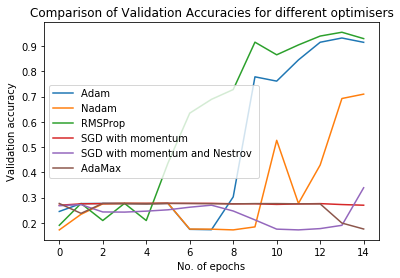

In [0]:
# Comparison of Validation Accuracies for different optimisers
plt.title('Comparison of Validation Accuracies for different optimisers')
plt.plot(history_adam.history['val_acc'], label='Adam ')
plt.plot(history_nadam.history['val_acc'], label='Nadam ')
plt.plot(history_rmsprop.history['val_acc'], label='RMSProp ')
plt.plot(history_sgdmom.history['val_acc'], label='SGD with momentum')
plt.plot(history_sgdmomnes.history['val_acc'], label='SGD with momentum and Nestrov ')
plt.plot(history_adamax.history['val_acc'], label='AdaMax ')

plt.ylabel('Validation accuracy')  
plt.xlabel('No. of epochs')
plt.legend()
plt.show()

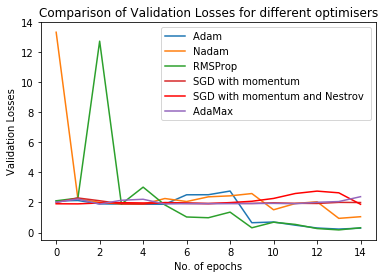

In [0]:
# Comparison of Validation loss for different optimisers
plt.title('Comparison of Validation Losses for different optimisers')
plt.plot(history_adam.history['val_loss'], label='Adam ')
plt.plot(history_nadam.history['val_loss'], label='Nadam ')
plt.plot(history_rmsprop.history['val_loss'], label='RMSProp ')
plt.plot(history_sgdmom.history['val_loss'], label='SGD with momentum')
plt.plot(history_sgdmomnes.history['val_loss'],'red', label='SGD with momentum and Nestrov ')
plt.plot(history_adamax.history['val_loss'], label='AdaMax ')

plt.ylabel('Validation Losses')  
plt.xlabel('No. of epochs')
plt.legend()
plt.show()

# Interpretation and Visualization of the internal layers of CNNs













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




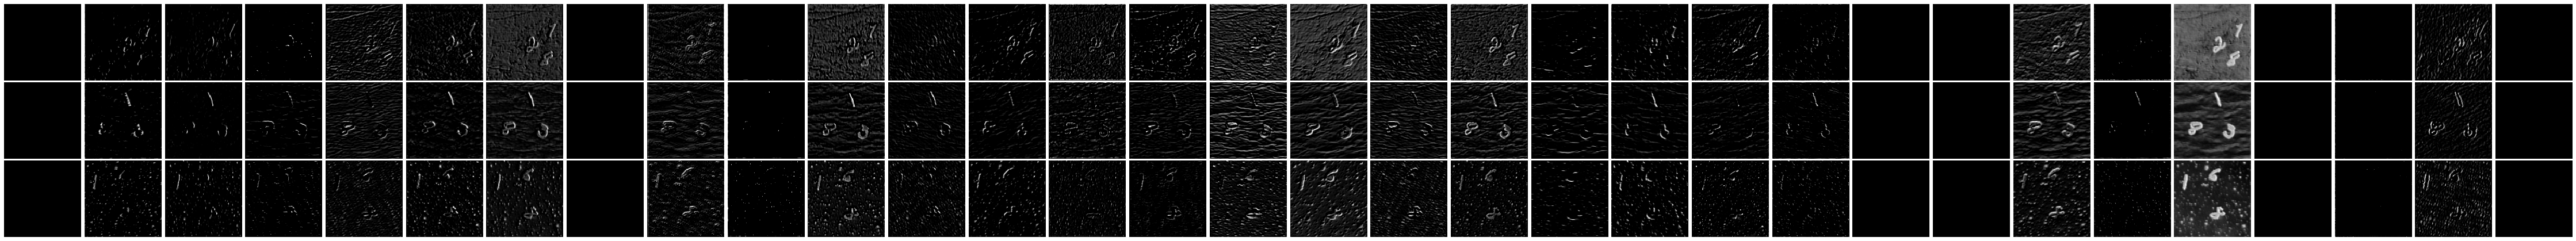

In [0]:
# Selecting sample model for extracting internal visualizations
selected_model = load_model(glob.glob("./Final_models/*.hdf5")[0])

# Editing model to extract output from 1st layer
edit_model = Model(inputs=selected_model.inputs, outputs=selected_model.layers[1].output)

# Creating feature maps using 3 randomly selected sample images
feature_maps = edit_model.predict(X_test_d[[0,5,10]])#.reshape((1,128,128,1)))

# Plot the figures for all feature maps from each of the 3 randomly selected sample images

plt.figure(figsize=(80,10))
for j in range(3):
    for i in range(32):
        plt.subplot(3,32,j*32+i+1)
        plt.imshow(feature_maps[j,:,:,i], cmap = "gray")
        plt.axis("off")
plt.subplots_adjust(wspace=0.05, hspace=-0.5)
#plt.tight_layout()

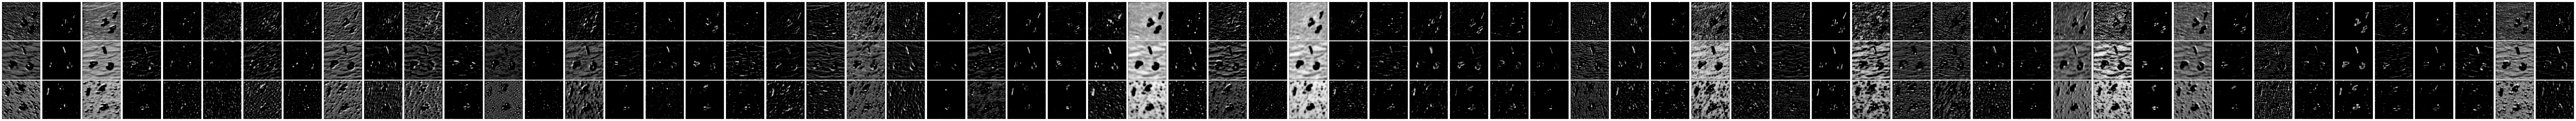

In [0]:
# Selecting sample model for extracting internal visualizations
selected_model = load_model(glob.glob("./Final_models/*.hdf5")[0])

# Editing model to extract output from 6th layer
edit_model = Model(inputs=selected_model.inputs, outputs=selected_model.layers[6].output)

# Creating feature maps using 3 randomly selected sample images
feature_maps = edit_model.predict(X_test_d[[0,5,10]])#.reshape((1,128,128,1)))

# Plot the figures for all feature maps from each of the 3 randomly selected sample images

plt.figure(figsize=(160,10))
for j in range(3):
    for i in range(64):
        plt.subplot(3,64,j*64+i+1)
        plt.imshow(feature_maps[j,:,:,i], cmap = "gray")
        plt.axis("off")
plt.subplots_adjust(wspace=0.05, hspace=-0.5)
#plt.tight_layout()

# Thresholding based approach (Not selected in our final model)

In [0]:
# Thresholding
thresh_val, train_images_thresh = cv2.threshold(Train_images, 240, 255, cv2.THRESH_BINARY)

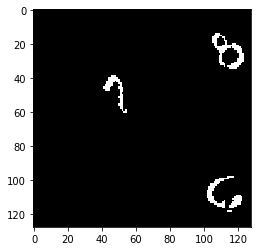

In [0]:
# Example image
plt.imshow(train_images_thresh[5], cmap="gray")
plt.show()

In [0]:
# One hot encoding
y_train = to_categorical(y_train["Label"])

# Reshape and normalize training data
train_images_thresh = train_images_thresh.reshape(train_images_thresh.shape[0],128,128,1)
train_images_thresh_sd = normalize(train_images_thresh)

# Split into training and Hold-out validation datasets
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(train_images_thresh_sd, y_train, test_size=0.2, random_state=42)

# Data augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.2,
    shear_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    )

datagen.fit(X_train_d)

In [0]:
# Model Training and Validation
model1 = VGG_modified((128,128,1))#CNN_3L
model1.fit_generator(datagen.flow(X_train_d, y_train_d, batch_size=200), 
                     epochs=30, validation_data = (X_test_d, y_test_d))

We notice that the results from Thresholding approach were above the TA Baseline, but were not sufficient for a very high score (of above 99% accuracy on the Kaggle competition)

# Bounding Box Preprocessing approaches  (Not selected in our final model)
In this method, we aim to use bounding boxes preprocessing and perform classification using following steps:

1.   Create bunding boxes around the digits using Computer Vision
2.   Extract the digit using Computer vision
3.   Classify the digit using a trained (or pre-trained) MNIST model
4.   Manually Check largest value of the digits classified


In [0]:
'''
FUNCTIONS REQUIRED TO PERFORM BOUNDING BOX PREPROCESSING
'''

# Function to convert the image from greyscale to black and white
def threshold_image(img, thresh=240, maxValue=255):
    '''
    This function turns the raw original image into binary(black and white) image using cv2.threshold
    '''
    # turn image to binary values
    ret, thresh = cv2.threshold(img, thresh, maxValue, cv2.THRESH_BINARY)  
      
    # convert to unsigned 8 bit to work with findContours()
    thresh = thresh.astype(np.uint8)

    return thresh

# Function to get the digits present in one image using the bounding box approach by finding the contours
def get_bounding_box(img,thresh=240,maxValue=255):
    ''' 
    This function returns the subimages from image using bounding box approach (cv2.boundingRect())
    '''  
    # turn image to binary values that is black and white instead of greyscale. 
    dst = threshold_image(img)
    
    # Finding the Contours using cv2.findContours()
    _, contours, hier = cv2.findContours(dst, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    #print("Number of Contours found = " + str(len(contours)))
      
    # getting subimages from the contours
    images = []
    for cnt in contours:
      x, y, width, height = cv2.boundingRect(cnt)  
      images.append(img[y: y+height, x:x+width])
      
    return images

def get_image(images):
    count=[]
    image=[]
    index=[]

    for img in images:
        
    # Finding the larger dimension that is the height or the width for each image   
        count.append(img.shape[0]*img.shape[1])
        lst=sorted(count,reverse=True)[:3]
        
    # Finding the largest dimension of all the images in the dataset  
    for i in lst:
        index.append(count.index(i))

    for j in index:
        image.append(images[j])

    # Returing the image 
    return image

# Function that resizes the image with padding
def resize_pad_image(img, size=(20,20), pad = 4):
    '''
    This function resizes the image by interpolation method and we get scaled image by padding
    '''
    height, width = img.shape[:2]
    shrink_height, shrink_width = size
    
    # shrink image using interpolation
    if height > shrink_height or width > shrink_width: 
        interpolate_image = cv2.INTER_AREA
    # stretch image using interpolation
    else: 
        interpolate_image = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect_ratio = width/height  

    # Scaling the image and pad sizing
    # horizontal image if aspect ratio > 1
    if aspect_ratio > 1: 
        width_new = shrink_width
        height_new = np.round(width_new/aspect_ratio).astype(int)
        pad_vertical = (shrink_height-height_new)/2
        pad_top, pad_botttom = np.floor(pad_vertical).astype(int), np.ceil(pad_vertical).astype(int)
        pad_left, pad_right = 0, 0
    # vertical image if aspect ratio < 1
    elif aspect_ratio < 1: 
        height_new = shrink_height
        width_new = np.round(height_new*aspect_ratio).astype(int)
        pad_horizontal = (shrink_width-width_new)/2
        pad_left, pad_right = np.floor(pad_horizontal).astype(int), np.ceil(pad_horizontal).astype(int)
        pad_top, pad_botttom = 0, 0
    # square image
    else: 
        height_new, width_new = shrink_height, shrink_width
        pad_left, pad_right, pad_top, pad_botttom = 0, 0, 0, 0

    # scale and pad
    padColor = 0
    scaled_image = cv2.resize(img, (width_new, height_new), interpolation=interpolate_image)
    scaled_image = cv2.copyMakeBorder(scaled_image, pad_top, pad_botttom, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)
    scaled_image = cv2.copyMakeBorder(scaled_image, pad, pad, pad, pad, borderType=0)
    return scaled_image

'''
This is the main preprocess function which calls other functions to get the digit with largest area
'''
def preprocess_image(data):
    preprocess_data = []
    #data=[]
    for image in data:
        images=threshold_image(image)
    # for getting the subimages
        sub_images =  get_bounding_box(images.reshape(128,128))
    # finding the number with largest area
        largest_area = get_image(sub_images)    
    # rescaling it
        for i in largest_area:
            rescaled = resize_pad_image(i)
            #show_image(rescaled)
            preprocess_data.append(rescaled)
        #data.append(preprocess_data)
    return np.asarray(preprocess_data)

In [0]:
# We get processed train and test images
X_train_processed = preprocess_image(Train_images)

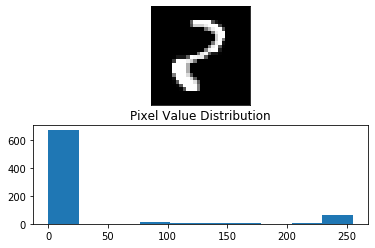

In [0]:
# Example image extracted from Bounding Box approach, along with its Pixel-value distribution
fig = plt.figure()
plt.subplot(2,1,1)
plt.imshow(X_train_processed[1], cmap='gray', interpolation='none')
#plt.title("Digit: {}".format(Y_train[0]))
plt.xticks([])
plt.yticks([])
plt.subplot(2,1,2)
plt.hist(X_train_processed[1].reshape(784))
plt.title("Pixel Value Distribution")
plt.show()

In [0]:
# Normalising the images
X_train_processed_N = X_train_processed/255
#X_test_processed_N  = X_test_processed/255

# Reshaping to feed the model
X_train_processed_N = X_train_processed_N.reshape(X_train_processed_N.shape[0], 28, 28, 1).astype('float32')
#X_test_processed_N  = X_test_processed_N.reshape(X_test_processed_N.shape[0], 28, 28, 1).astype('float32')

# Training and validation split
#x_train, x_test, y_train, y_test = train_test_split( X_train_processed_N, Y_train, test_size=0.1, random_state=None)
y_train = to_categorical(Y_train)



In [0]:
# Original MNIST Dataset preprocessing and training

# Loading MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# PREPROCESSING MNIST DATASET
# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255

# MODEL TO TRAIN MNIST DATASET
# Creating a Sequential Model and adding the layers
model = Sequential()
model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(10,activation=tf.nn.softmax))

# Training MNIST DATASET
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(x=x_train,y=y_train, epochs=10)

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/10
60000/60000 [==============================] - 8s 140us/step - loss: 0.2040 - acc: 0.9392
Epoch 2/10
60000/60000 [==============================] - 7s 119us/step - loss: 0.0838 - acc: 0.9741
Epoch 3/10
60000/60000 [==============================] - 7s 120us/step - loss: 0.0603 - acc: 0.9807
Epoch 4/10
60000/60000 [==============================] - 7s 122us/step - loss: 0.0446 - acc: 0.9859
Epoch 5/10
60000/60000 [==============================] - 7s 120us/step - loss: 0.0370 - acc: 0.9880
Epoch 6/10
60000/60000 [==============================] - 7s 121us/step - loss: 0.0298 - acc: 0.9897
Epoch 7/10
60000/60000 [==============================] - 7s 121us/step - loss: 0.0266 - acc: 0.9911
Epoch 8/10
60000/60000 [==============================] - 7s 120us/step - loss: 0.0227 - acc: 0.9919
Epoch 9/10
60000/60000 [==============================] - 7s 122us/step - loss: 0.0203 - acc: 0.9931
Epoch 10/10
60000/60000 [=

In [0]:
# PREDICTING DIGIT ON TASK DATASET USING TRAINED MNIST MODEL
pred=[]
pred = model.predict(X_train_processed.reshape(X_train_processed.shape[0], 28,28, 1))

pred1=[]
for j in range(150000):
    pred1.append(pred[j].argmax())

Z=[]
for i in range(50000):
    Z.append(max(pred1[3*i:3*i+3]))

print("Accuracy of predicting max number in image using bounding box approach: ", accuracy_score(Z,Y_train))

Accuracy of predicting max number in image using bounding box approach:  0.49608


We notice that the bounding box approaches did not work. An important finding is that classical Computer Vision techniques implemented to extract the bounding boxes, further skew, occlude and add noise to the digit image. Since the MNIST dataset originally may not have such transformations on the images, the performance on the Modified MNIST dataset is poor.

# Padding image to form 84x84 size (Not selected in our final model)

In [0]:
def createImageGrid(images):
    joinedImages = np.hstack(images)
    squareJoinedImages = cv2.copyMakeBorder(joinedImages,28,28,0,0,cv2.BORDER_CONSTANT,0)
    return squareJoinedImages

In [0]:
X=[]
for i in range(10000):
    X.append(createImageGrid(X_test_processed[3*i:3*i+3]))
X_test_processed=np.asarray(X)

Y=[]
for i in range(50000):
    Y.append(createImageGrid(X_train_processed[3*i:3*i+3]))
X_train_processed=np.asarray(Y)

In [0]:
X_test_processed=X_test_processed.reshape(X_test_processed.shape[0],84,84,1)
X_train_processed=X_train_processed.reshape(X_train_processed.shape[0],84,84,1)

In [0]:
plt.imshow(X_test_processed[50].reshape(X_test_processed.shape[1],X_test_processed.shape[2]))

In [0]:
# Data Augumentation
datagen = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.2,
    shear_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    )

datagen.fit(X_train_processed)